In [1]:
'''
dataset: https://finance.yahoo.com/quote/GOOG/history?p=GOOG
The code for the data format was adapted from this github repository: https://github.com/bnsreenu/python_for_microscopists
'''

import numpy as np
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense, Dropout, SimpleRNN
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler
import seaborn as sns


#Read the csv file
df = pd.read_csv('C:/Users/craci/DataSpellProjects/Adaptation_NNfs/StockMarketDataset/GOOG.csv')


print(df.head()) #7 columns, including the Date.

         Date       Open       High        Low      Close  Adj Close    Volume
0  2017-10-17  49.514500  49.821999  49.429501  49.609001  49.609001  25804000
1  2017-10-18  49.588501  49.835999  49.348751  49.640499  49.640499  21152000
2  2017-10-19  49.299999  49.444000  48.919498  49.222500  49.222500  26272000
3  2017-10-20  49.472000  49.549999  49.229000  49.410000  49.410000  23664000
4  2017-10-23  49.476002  49.476002  48.306000  48.422501  48.422501  29568000


In [2]:
#Separate dates for future plotting
train_dates = pd.to_datetime(df['Date'])
print(train_dates.tail(15)) #Check last few dates.

1243   2022-09-26
1244   2022-09-27
1245   2022-09-28
1246   2022-09-29
1247   2022-09-30
1248   2022-10-03
1249   2022-10-04
1250   2022-10-05
1251   2022-10-06
1252   2022-10-07
1253   2022-10-10
1254   2022-10-11
1255   2022-10-12
1256   2022-10-13
1257   2022-10-14
Name: Date, dtype: datetime64[ns]


['Open', 'High', 'Low', 'Close', 'Adj Close']


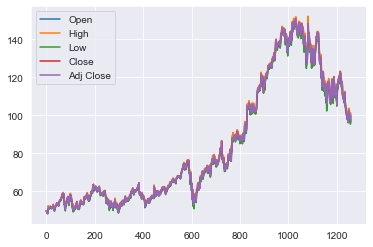

In [3]:
#Variables for training
cols = list(df)[1:6]
#Date and volume columns are not used in training.
print(cols) #['Open', 'High', 'Low', 'Close', 'Adj Close']

#New dataframe with only training data - 5 columns
df_for_training = df[cols].astype(float)

df_for_plot=df_for_training.tail(5000)
df_for_plot.plot.line()

In [4]:
from sklearn.model_selection import train_test_split

class Scaler_1_1():

    def __init__(self, x):

        self.min_x = x.min()
        x_s= x  - self.min_x
        self.max_x = x_s.max()

    def scale_forward(self, x):

        x-=self.min_x
        x_final = x/ x.max() * 2 - 1

        return x_final

    def scale_back(self, x):

        x_final = (x +1)/2 * self.max_x


# normalize the dataset
scaler = StandardScaler()
scaler = scaler.fit(df_for_training)
df_for_training_scaled = scaler.transform(df_for_training)

#second_scalere = Scaler_1_1(df_for_training_scaled)
#df_for_training_scaled = second_scalere.scale_forward(df_for_training_scaled)


print(df_for_training_scaled.shape)
print(df_for_training_scaled.min())
print(df_for_training_scaled.max())

#In this example, the n_features is 5. We will make timesteps = 14 (past days data used for training).

#Empty lists to be populated using formatted training data
X = []
Y = []

n_future = 1   # Number of days we want to look into the future based on the past days.
n_past = 2  # Number of past days we want to use to predict the future.

#Reformat input data into a shape: (n_samples x timesteps x n_features)
#In my example, my df_for_training_scaled has a shape (1258, 5)
#1258 refers to the number of data points and 5 refers to the columns (multi-variables)
#This model is going to predict the closing price for the next trading day
for i in range(n_past, len(df_for_training_scaled) - n_future +1):
    X.append(df_for_training_scaled[i - n_past:i, 0:df_for_training.shape[1]])
    Y.append(df_for_training_scaled[i + n_future - 1:i + n_future, 3])

X, Y = np.array(X), np.array(Y)

print('X shape == {}.'.format(X.shape))
print('Y shape == {}.'.format(Y.shape))

train_split = int(len(X)/100 * 80)
valid_split = train_split + int(len(X)/100 * 10)

print(len(X))
print(train_split)
print(valid_split)

x_train, y_train = X[0:train_split], Y[0:train_split]
x_valid, y_valid = X[train_split:valid_split], Y[train_split:valid_split]
x_test, y_test = X[valid_split:], Y[valid_split:]

print(np.shape(x_train))
print(np.shape(x_valid))
print(np.shape(x_test))


(1258, 5)
-1.1298378553142838
2.120081597526207
X shape == (1256, 2, 5).
Y shape == (1256, 1).
1256
1004
1129
(1004, 2, 5)
(125, 2, 5)
(127, 2, 5)


In [5]:

model_keras_lstm = Sequential()
model_keras_lstm.add(LSTM(64, activation='relu', input_shape=(x_train.shape[1], x_train.shape[2]), return_sequences=False))
#model_keras_lstm.add(LSTM(32, activation='relu', return_sequences=False))
model_keras_lstm.add(Dropout(0.2))
model_keras_lstm.add(Dense(Y.shape[1]))

model_keras_lstm.compile(optimizer='adam', loss='mse')
model_keras_lstm.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 64)                17920     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 1)                 65        
                                                                 
Total params: 17,985
Trainable params: 17,985
Non-trainable params: 0
_________________________________________________________________


In [6]:

model_keras_rnn = Sequential()
model_keras_rnn.add(SimpleRNN(64, activation='relu', input_shape=(x_train.shape[1], x_train.shape[2]), return_sequences=False))
#model_keras_rnn.add(SimpleRNN(32, activation='relu', input_shape=(x_train.shape[1], x_train.shape[2]), return_sequences=False))
model_keras_rnn.add(Dropout(0.2))
model_keras_rnn.add(Dense(Y.shape[1]))

model_keras_rnn.compile(optimizer='adam', loss='mse')
model_keras_rnn.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 64)                4480      
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 4,545
Trainable params: 4,545
Non-trainable params: 0
_________________________________________________________________


In [7]:


# fit the model_keras_lstm
history_lstm = model_keras_lstm.fit(x_train, y_train, epochs=5, batch_size=16, validation_data=(x_valid, y_valid), verbose=1)

Epoch 1/5
63/63 [==============================] - 3s 15ms/step - loss: 0.3837 - val_loss: 0.1030
Epoch 2/5
63/63 [==============================] - 1s 13ms/step - loss: 0.0206 - val_loss: 0.0466
Epoch 3/5
63/63 [==============================] - 1s 11ms/step - loss: 0.0164 - val_loss: 0.0133
Epoch 4/5
63/63 [==============================] - 1s 11ms/step - loss: 0.0163 - val_loss: 0.0157
Epoch 5/5
63/63 [==============================] - 1s 11ms/step - loss: 0.0140 - val_loss: 0.0200


In [8]:

# fit the model_keras_rnn
history_rnn = model_keras_rnn.fit(x_train, y_train, epochs=5, batch_size=16, validation_data=(x_valid, y_valid), verbose=1)

Epoch 1/5
63/63 [==============================] - 1s 9ms/step - loss: 0.2290 - val_loss: 0.0163
Epoch 2/5
63/63 [==============================] - 0s 6ms/step - loss: 0.0409 - val_loss: 0.0159
Epoch 3/5
63/63 [==============================] - 0s 6ms/step - loss: 0.0301 - val_loss: 0.0223
Epoch 4/5
63/63 [==============================] - 0s 7ms/step - loss: 0.0204 - val_loss: 0.0132
Epoch 5/5
63/63 [==============================] - 0s 7ms/step - loss: 0.0188 - val_loss: 0.0196


In [9]:
%load_ext autoreload
%autoreload 2

from  NNImplementation import BasicClasses as cls
from  NNImplementation import RNNClasses as rnn

epochs = 50
batch_size = 16
input_clases = x_train.shape[2]
memory_duration = x_train.shape[1]
layer1_neurons = 64
layer2_neurons = 32

optimizerRNN = rnn.OptimizerAdamRNN(learning_rate=0.001)
simple_optimizer = cls.OptimizerAdam(learning_rate=0.001)

layer1_rnn = rnn.RNNLayer(input_clases, layer1_neurons, activation=cls.ActivationLinear(), memory_duration=memory_duration)
layer3_rnn = cls.Layer(layer1_neurons, 1)
activation3_rnn = cls.ActivationSigmoid()
loss_rnn = cls.LossMeanSquaredError()

def reshape_inputs(x_current):

    x_current = np.array([[x_current[i,j]   for i in range(len(x_current))] for j in range(len(x_current[0]))])

    return x_current

def forward_rnn(memory_duration, X_current, Y_current, add_epsilon=False, epsilon=0):

    X_current = reshape_inputs(X_current)
    layer1_rnn.forward_through_time(X_current, add_epsilon=add_epsilon, epsilon=epsilon)
    layer3_rnn.forward(layer1_rnn.outputs)
    activation3_rnn.forward(layer3_rnn.outputs)
    loss_rnn.forward(activation3_rnn.outputs, Y_current[memory_duration-1])

    return activation3_rnn.outputs

def backward_rnn(memory_duration, X_current, Y_current):

    X_current = reshape_inputs(X_current)
    loss_rnn.backward(activation3_rnn.outputs, Y_current[memory_duration - 1])
    activation3_rnn.backward(loss_rnn.dinputs)
    layer3_rnn.backward(activation3_rnn.dinputs)
    layer1_rnn.backward_through_time(layer3_rnn.dinputs, X_current)

    return layer1_rnn.deposit

In [10]:
%load_ext autoreload
%autoreload 2

checker = cls.GradientChecker()

for epoch in range(epochs):

    part_length = int(len(x_train) / batch_size)

    if part_length * batch_size < len(x_train):
        part_length += 1

    batch_loss = 0
    result_final=0
    target_final=0

    for i in range(part_length):

        x_current = X[i * batch_size:(i + 1) * batch_size]
        y_current = Y[i * batch_size:(i + 1) * batch_size]

        memory = [np.zeros((batch_size, layer1_neurons))]

        forward_rnn(memory_duration, x_current, y_current)
        backward_rnn(memory_duration, x_current, y_current)

        result, target = checker.check_custom(loss=loss_rnn, forward=forward_rnn, backward=backward_rnn, X=x_current, Y=y_current, memory_duration=memory_duration, print_out=False)

        result_final+=result
        target_final+=target


        optimizerRNN.pre_update_params()
        simple_optimizer.pre_update_params()
        optimizerRNN.update_params(layer1_rnn)
        simple_optimizer.update_params(layer3_rnn)

        batch_loss += np.average(loss_rnn.outputs)

    batch_loss /= part_length
    result_final/= part_length
    target_final/=part_length


    print("Loss at epoch {} is: {}".format(epoch, batch_loss))
    print(result_final)
    print(target_final)



The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Loss at epoch 0 is: 1.0808504933876857
-0.0006374628264594319
-0.000637461560981265
Loss at epoch 1 is: 0.5095329579549063
-7.155027499118057e-05
-7.155321361944846e-05
Loss at epoch 2 is: 0.5013798826934307
2.527608821610213e-06
2.5239238165531736e-06
Loss at epoch 3 is: 0.5002137230848391
5.224145365373127e-06
5.226363346590646e-06
Loss at epoch 4 is: 0.4985818551388143
6.85187799936861e-06
6.86482354695789e-06
Loss at epoch 5 is: 0.495428821506714
4.5756350988158045e-06
4.590307281999795e-06
Loss at epoch 6 is: 0.49564305057280583
5.262958229765904e-07
5.333586873506508e-07
Loss at epoch 7 is: 0.496594328467958
5.72785481064585e-06
5.730786455193281e-06
Loss at epoch 8 is: 0.49607586211143295
6.000760577358092e-07
6.018777716606669e-07
Loss at epoch 9 is: 0.49724065553048735
5.624276510039768e-06
5.618669972974433e-06
Loss at epoch 10 is: 0.4953186445783009
4.901855954657779e-07
4.911025475744463

In [11]:
%load_ext autoreload
%autoreload 2

from  NNImplementation import BasicClasses as cls
from  NNImplementation import RNNClasses as rnn

epochs = 20
batch_size = 16
input_clases = x_train.shape[2]
memory_duration = x_train.shape[1]
layer1_neurons = 64
layer2_neurons = 32

optimizerRNN = rnn.OptimizerAdamLstm(learning_rate=0.001)
simple_optimizer = cls.OptimizerAdam(learning_rate=0.001)

layer1_lstm = rnn.LstmLayer(input_clases, layer1_neurons, memory_duration=memory_duration)
activation1_lstm = cls.ActivationReLU()
layer2_lstm = cls.Layer(layer1_neurons, layer2_neurons)
activation2_lstm = cls.ActivationReLU()
layer3_lstm = cls.Layer(layer2_neurons, 1)
activation3_lstm = cls.ActivationSigmoid()
loss_lstm = cls.LossMeanSquaredError()

def reshape_inputs(x_current):

    x_current = np.array([[x_current[i,j]   for i in range(len(x_current))] for j in range(len(x_current[0]))])

    return x_current

def forward_lstm(memory_duration, X_current, Y_current, add_epsilon=False, epsilon=0):

    X_current = reshape_inputs(X_current)
    layer1_lstm.forward_through_time(X_current, add_epsilon=add_epsilon, epsilon=epsilon)
    activation1_lstm.forward(layer1_lstm.outputs)
    layer2_lstm.forward(activation1_lstm.outputs)
    activation2_lstm.forward(layer2_lstm.outputs)
    layer3_lstm.forward(activation2_lstm.outputs)
    activation3_lstm.forward(layer3_lstm.outputs)
    loss_lstm.forward(activation3_lstm.outputs, Y_current[memory_duration-1])

    return activation3_lstm.outputs

def backward_lstm(memory_duration, X_current, Y_current):

    X_current = reshape_inputs(X_current)
    loss_lstm.backward(activation3_lstm.outputs, Y_current[memory_duration - 1])
    activation3_lstm.backward(loss_lstm.dinputs)
    layer3_lstm.backward(activation3_lstm.dinputs)
    activation2_lstm.backward(layer3_lstm.dinputs)
    layer2_lstm.backward(activation2_lstm.dinputs)
    activation1_lstm.backward(layer2_lstm.dinputs)
    layer1_lstm.backward_through_time(activation1_lstm.dinputs, X_current)

    return layer1_lstm.deposit

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [12]:
%load_ext autoreload
%autoreload 2

#checker = cls.GradientChecker()

for epoch in range(epochs):

    part_length = int(len(x_train) / batch_size)

    if part_length * batch_size < len(x_train):
        part_length += 1

    batch_loss = 0

    for i in range(part_length):

        x_current = X[i * batch_size:(i + 1) * batch_size]
        y_current = Y[i * batch_size:(i + 1) * batch_size]

        memory = [np.zeros((batch_size, layer1_neurons))]

        forward_lstm(memory_duration, x_current, y_current)
        backward_lstm(memory_duration, x_current, y_current)

        optimizerRNN.pre_update_params()
        simple_optimizer.pre_update_params()
        optimizerRNN.update_params(layer1_lstm)
        simple_optimizer.update_params(layer2_lstm)

        batch_loss += np.average(loss_lstm.outputs)

    batch_loss /= part_length

    print("Loss at epoch {} is: {}".format(epoch, batch_loss))



The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Loss at epoch 0 is: 1.3276277288468252
Loss at epoch 1 is: 1.2916708613217145
Loss at epoch 2 is: 1.18879239179308
Loss at epoch 3 is: 1.101581900461118
Loss at epoch 4 is: 1.0351764719531202
Loss at epoch 5 is: 0.9805815918158164
Loss at epoch 6 is: 0.9343220628945078
Loss at epoch 7 is: 0.8945416138171572
Loss at epoch 8 is: 0.8600325706883702
Loss at epoch 9 is: 0.8299114256732721
Loss at epoch 10 is: 0.8034864929220926
Loss at epoch 11 is: 0.7802035589929393
Loss at epoch 12 is: 0.7595893588272249
Loss at epoch 13 is: 0.7412519559977645
Loss at epoch 14 is: 0.7248681604042847
Loss at epoch 15 is: 0.7101751476877258
Loss at epoch 16 is: 0.6969426611148895
Loss at epoch 17 is: 0.6849668906035915
Loss at epoch 18 is: 0.6741114193442077
Loss at epoch 19 is: 0.6642061887418763


127
127/127 [==============================] - 0s 2ms/step
(127, 1)
(127, 1)


<ipython-input-13-cdf6fcf01195>:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  original['Date']=pd.to_datetime(original['Date'])


ValueError: `legend` must be 'auto', 'brief', 'full', or a boolean.

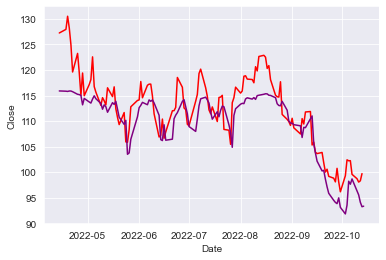

In [13]:
#Here we will compare the performances of our diffrent models
#Libraries that will help us extract only business days in the US.
#Otherwise our dates would be wrong when we look back (or forward).
from pandas.tseries.holiday import USFederalHolidayCalendar
from pandas.tseries.offsets import CustomBusinessDay
us_bd = CustomBusinessDay(calendar=USFederalHolidayCalendar())
#Remember that we can only predict one day in future as our model needs 5 variables
#as inputs for prediction. We only have all 5 variables until the last day in our dataset.
n_past = len(x_test)
n_days_for_prediction = len(x_test) #let us predict past 15 days

predict_period_dates = pd.date_range(list(train_dates)[-n_past], periods=n_days_for_prediction, freq=us_bd).tolist()
print(len(predict_period_dates))

#Make prediction
prediction_lstm_keras = model_keras_lstm.predict(x_test, batch_size=1) #shape = (n, 1) where n is the n_days_for_prediction
prediction_rnn_keras = model_keras_rnn.predict(x_test, batch_size=1) #shape = (n, 1) where n is the n_days_for_prediction
prediction_rnn_nnfs = forward_rnn(memory_duration, x_test, y_test)
prediction_lstm_nnfs = forward_lstm(memory_duration, x_test, y_test)


print(np.shape(prediction_lstm_nnfs))
print(np.shape(prediction_lstm_keras))

#Perform inverse transformation to rescale back to original range
#Since we used 5 variables for transform, the inverse expects same dimensions
#Therefore, let us copy our values 5 times and discard them after inverse transform
prediction_copies_lstm = np.repeat(prediction_lstm_keras, df_for_training.shape[1], axis=-1)
prediction_copies_rnn = np.repeat(prediction_rnn_keras, df_for_training.shape[1], axis=-1)
prediction_copies_rnn_nnfs = np.repeat(prediction_rnn_nnfs, df_for_training.shape[1], axis=-1)
prediction_copies_lstm_nnfs = np.repeat(prediction_lstm_nnfs, df_for_training.shape[1], axis=-1)

y_pred_future_lstm_nnfs = scaler.inverse_transform(prediction_copies_lstm_nnfs)[:,0]
y_pred_future_lstm = scaler.inverse_transform(prediction_copies_lstm)[:,0]
y_pred_future_rnn_nnfs = scaler.inverse_transform(prediction_copies_rnn_nnfs)[:,0]
y_pred_future_rnn = scaler.inverse_transform(prediction_copies_rnn)[:,0]

# Convert timestamp to date
forecast_dates = []
for time_i in predict_period_dates:
    forecast_dates.append(time_i.date())

df_forecast_rnn_nnfs = pd.DataFrame({'Date':np.array(forecast_dates), 'Close':y_pred_future_rnn_nnfs})
df_forecast_lstm_nnfs = pd.DataFrame({'Date':np.array(forecast_dates), 'Close':y_pred_future_lstm_nnfs})
df_forecast_lstm = pd.DataFrame({'Date':np.array(forecast_dates), 'Close':y_pred_future_lstm})
df_forecast_rnn = pd.DataFrame({'Date':np.array(forecast_dates), 'Close':y_pred_future_rnn})

df_forecast_rnn_nnfs['Date']=pd.to_datetime(df_forecast_rnn_nnfs['Date'])
df_forecast_lstm_nnfs['Date']=pd.to_datetime(df_forecast_lstm_nnfs['Date'])
df_forecast_lstm['Date']=pd.to_datetime(df_forecast_lstm['Date'])
df_forecast_rnn['Date']=pd.to_datetime(df_forecast_rnn['Date'])

original = df[['Date', 'Close']]
original['Date']=pd.to_datetime(original['Date'])

sns.lineplot(x=original['Date'][-n_days_for_prediction:-1], y=original['Close'][-n_days_for_prediction:-1], color="red")

sns.lineplot(x=df_forecast_rnn_nnfs['Date'], y=df_forecast_rnn_nnfs['Close'], color="purple")
#sns.lineplot(x=df_forecast_lstm['Date'], y=df_forecast_lstm['Close'], color="blue")
sns.lineplot(x=df_forecast_rnn['Date'], y=df_forecast_rnn['Close'], color="green")

In [ ]:
sns.lineplot(x=original['Date'][-n_days_for_prediction:-1], y=original['Close'][-n_days_for_prediction:-1], color="red")

sns.lineplot(x=df_forecast_lstm_nnfs['Date'], y=df_forecast_lstm_nnfs['Close'], color="yellow")
sns.lineplot(x=df_forecast_lstm['Date'], y=df_forecast_lstm['Close'], color="blue")